In [1]:
from skimage.io import imread
import os
import cv2
from skimage.transform import resize
import numpy as np
import copy

from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import segmentation_models_pytorch as smp

import pickle 

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import yaml

from typing import Any

import warnings
warnings.filterwarnings("ignore")

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

random_state = config['train']['random_sate']

In [ ]:
torch.manual_seed(random_state)

# Сегментация дорог со спутниковых изображений

В данной работе ставится задача сегментации Российских дорог со спутниковых изображений Google Maps. Планируется протестировать две нейронных сети (Unet, DeepLabV3Plus) на разных функциях потерь. В конце работы провести сравнительный анализ различных моделей по метрике IoU (Intersection Over Union), а также оценить их переобучение.

# 1. Загрузка данных
Загрузим картинки с двух папок: images (реальные фотографии) и groundtruth (маски, соответствующие фотографиям из images). Сохраним их в Dataloader'ы и выведем на экран.

In [6]:
images_path = config['train']['images_path']
groundtruth_path = config['train']['groundtruth_path']

In [9]:
images = []
gt = []
for root, dirs, files in os.walk(images_path):
    files.sort()
    for im in files:
        images.append(imread(os.path.join(root, im)))
for root, dirs, files in os.walk(groundtruth_path):
    files.sort()
    for im in files:
        gt.append(imread(os.path.join(root, im)))

In [10]:
def image_gt_transformation(
    images: list, gt: list, size: tuple[int]
) -> (list, list):
    """
    Функция для преобразования изображений из списков. Приводит к формату RGB 
    и к типу float32
    :params images: список с изображениями WxHxC
    :params gt: список с масками WxH
    :params size: разрешение, к которому нужно привести все изображения
    :return: массивы с преобразованными изображениями и масками
    """
    X = [resize(cv2.cvtColor(x, cv2.COLOR_BGRA2BGR), size,
                mode='constant', anti_aliasing=True) for x in images]
    Y = [resize(y, size, mode='constant', anti_aliasing=False)
         > 0.5 for y in gt]

    X = np.array(X, np.float32)
    Y = np.array(Y, np.float32)

    return X, Y

In [11]:
size = config['train']['size']

In [12]:
X, Y = image_gt_transformation(images, gt, size)

In [9]:
def show_images_gt(images: np.array, gt: np.array) -> None:
    """
    Отрисовка изображени и масок
    :params images: массив с изображениями
    :params gt: массив с масками
    """
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(images[i])

        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(gt[i], cmap='gray')
    plt.show()

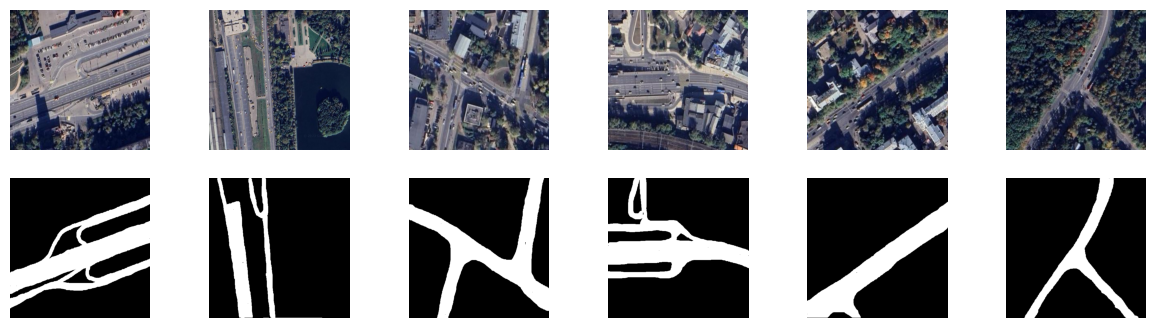

In [10]:
show_images_gt(X, Y)

In [17]:
def dataloader_builder(
    X: np.array, Y: np.array, train_size: float, batch_size: int, shuffle: bool
) -> (torch.utils.data.dataloader.DataLoader, 
      torch.utils.data.dataloader.DataLoader):
    """
    Разделение X и Y на train и val выборки. Построение тестовых 
    и валидационных даталоадеров
    :params X: массив с изображениями
    :params Y: массив с масками
    :params train_size: размер трейна
    :params batch_size: размер батча в даталоадере
    :params shuffle: перемешивание данных внутри даталоадеров
    :return: трейн даталоадер
    :return: тест даталоадер
    """
    train_size = int(len(X) * train_size)
    ix = np.random.choice(len(X), len(X), False)
    tr, val = np.split(ix, [train_size])

    data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                         batch_size=batch_size, shuffle=shuffle)
    data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), 
                                   Y[val, np.newaxis])), 
                          batch_size=batch_size, shuffle=shuffle)
    
    return data_tr, data_val

In [16]:
train_size = config['train']['train_size']
batch_size = config['train']['batch_size']
shuffle = config['train']['shuffle']

In [18]:
data_tr, data_val = dataloader_builder(X, Y, train_size, batch_size, shuffle)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. Обучение моделей
Определим метрику, функцию обучения. Построим сети и функции потерь. По ходу обучения буду выводить графики лоссов и метрики для трейна и теста.

## 2.1 Имплементация метрики, лоссов, нейросетей и цикла обучения

### 2.1.1 Метрика

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """
    Имплементация метрики Intersection Over Union.
    :params outputs: тензор выхода нейросети
    :params labels: тензор маски изображения
    :return: значение метрики
    """
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded

In [15]:
def score_model(
    model: Any, metric: function, data: torch.utils.data.dataloader.DataLoader
) -> float:
    """
    Аггрегация метрики по всем батчам из data.
    :params model: объект модели обучения
    :params metric: функция метрики
    :params data: даталоадер с изображениями и масками
    :return: усредненное значение метрики
    """
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        X_batch, Y_label = X_batch.to(device), Y_label.to(device)
        Y_pred = (model(X_batch) > 0.5).type(torch.long)
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

### 2.1.2 Цикл обучения

In [16]:
def train(
    model: Any, loss_fn: function, score_model: function, metric: function, 
    epochs: int, data_tr: torch.utils.data.dataloader.DataLoader, 
    data_val: torch.utils.data.dataloader.DataLoader
) -> (torch.utils.data.dataloader.DataLoader, dict):
    """
    Функция обучения модели. Попутно вывод графиков с выходами модели на валидации.
    :params model: объект модели обучения
    :params loss_fn: функция потерь
    :params score_model: функция, усредняющая метрику по батчам
    :params metric: функция метрики
    :params epochs: количество эпох обучения
    :params data_tr: трейн даталоадер
    :params data_val: тест даталоадер
    :return: объект наилучшей модели на валидации
    :return: словарь с лоссами и метриками на разных эпохах на трейне и тесте
    """
    X_val, Y_val = next(iter(data_val))
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    
    score_curr = 0
    model = copy.deepcopy(model)
    opt = optim.Adam(model.parameters())
    best_model = copy.deepcopy(model)

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            opt.zero_grad()
            Y_pred = model(X_batch)
            loss_tr = loss_fn(Y_batch, Y_pred)
            loss_tr.backward()
            opt.step()

            avg_loss += loss_tr / len(data_tr)
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss.to('cpu').detach().numpy().item())
        train_scores.append(score_model(model, metric, data_tr))
        val_scores.append(score_model(model, metric, data_val))
        
        if score_model(model, metric, data_val) > score_curr:
            best_model = copy.deepcopy(model)

        model.eval() 
        with torch.no_grad():
            Y_pred = model(X_val.to(device))
            loss_val = loss_fn(Y_val.to(device), Y_pred)
            val_losses.append(loss_val.to('cpu').detach().numpy().item())
            Y_hat = (Y_pred.to('cpu') > 0.5).type(torch.long).detach().numpy()

        clear_output(wait=True)
        for k in range(5):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()


    return best_model, {'train_losses': train_losses, 
                        'val_losses': val_losses, 
                        'train_scores': train_scores, 
                        'val_scores': val_scores}

### 2.1.3 Функции потерь

In [17]:
def bce_loss(y_real: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Имплементация функции потерь бинарной кросс-энтропии
    :params y_real: тензор маски изображения
    :params y_pred: тензор выхода нейросети
    :return: значение функции потерь
    """
    return torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))

In [18]:
def dice_loss(y_real: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Имплементация функции потерь dice
    :params y_real: тензор маски изображения
    :params y_pred: тензор выхода нейросети
    :return: значение функции потерь
    """
    pred = torch.sigmoid(pred)
    numerator = 2 * torch.mean(y_pred * y_real)
    denominator = torch.mean(y_pred + y_real)
    return 1 - (numerator + 1e-8) / (denominator + 1e-8)

In [19]:
def focal_loss(y_real: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Имплементация функции потерь focal
    :params y_real: тензор маски изображения
    :params y_pred: тензор выхода нейросети
    :return: значение функции потерь
    """
    y_pred = torch.clamp(torch.sigmoid(y_pred), 1e-8, 1 - 1e-8)
    loss = torch.mean(-(1 - y_pred) ** 2 * y_real * \
                      torch.log(y_pred) - (1 - y_real) * torch.log(1 - y_pred))
    return loss

In [20]:
def lovasz_grad(gt_sorted: torch.Tensor) -> torch.Tensor:
    """
    Расчет градиента lova функции потерь
    :params gt_sorted: отсортированный вектор ошибок
    :return: вектор градиента
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1 - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge_flat(y_real: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Имплементация функции потерь lova
    :params y_real: тензор маски изображения
    :params y_pred: тензор выхода нейросети
    :return: значение функции потерь
    """
    y_pred = y_pred.contiguous().view(-1)
    y_real = y_real.contiguous().view(-1)
    mask = y_real != 255
    y_pred = y_pred[mask]
    y_real = y_real[mask]

    signs = 2 * y_real - 1
    errors = 1 - y_pred * signs
    
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = y_real[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu(errors_sorted) + 1, grad)
    return loss

### 2.1.4 Архитектуры нейросетей

Построю вручную модель Unet, а модель DeepLabV3Plus скачаю с репозитория https://github.com/qubvel/segmentation_models.pytorch#start

In [21]:
class UNet(nn.Module):
    """
    Имлементация нейросети Unet
    """
    def __init__(self):
        """
        Имплементация слоев энкодера, боттлнек и декодера сети
        """
        super().__init__()
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, 2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, 2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, 2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, 2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, 2, stride=2, dilation=5, 
                                            padding=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, 2, stride=2, dilation=5, 
                                            padding=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2, dilation=5, 
                                            padding=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, stride=2, dilation=5, 
                                            padding=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 1, 3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход по сети
        :params x: вход сети (изображение)
        :return: выход сети (маска)
        """
        # encoder
        e0_conv = self.enc_conv0(x)
        e0_maxp = self.pool0(e0_conv)
        e1_conv = self.enc_conv1(e0_maxp)
        e1_maxp = self.pool1(e1_conv)
        e2_conv = self.enc_conv2(e1_maxp)
        e2_maxp = self.pool2(e2_conv)
        e3_conv = self.enc_conv3(e2_maxp)
        e3_maxp = self.pool3(e3_conv)

        # bottleneck
        b = self.bottleneck_conv(e3_maxp)

        # decoder
        d0 = self.dec_conv0(torch.cat((e3_conv, self.upsample0(b)), dim=1))
        d1 = self.dec_conv1(torch.cat((e2_conv, self.upsample1(d0)), dim=1))
        d2 = self.dec_conv2(torch.cat((e1_conv, self.upsample2(d1)), dim=1))
        d3 = self.dec_conv3(torch.cat((e0_conv, self.upsample3(d2)), dim=1))
        d3 = F.sigmoid(d3)
        return d3

In [22]:
unet_model = UNet().to(device)

In [23]:
deeplab_model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101',
    encoder_weights = 'imagenet',
    classes = 1,
    activation = None
).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 246MB/s]  


## 2.2 Обучение

### 2.2.1 Unet bce loss

In [22]:
epochs = config['train']['epochs']

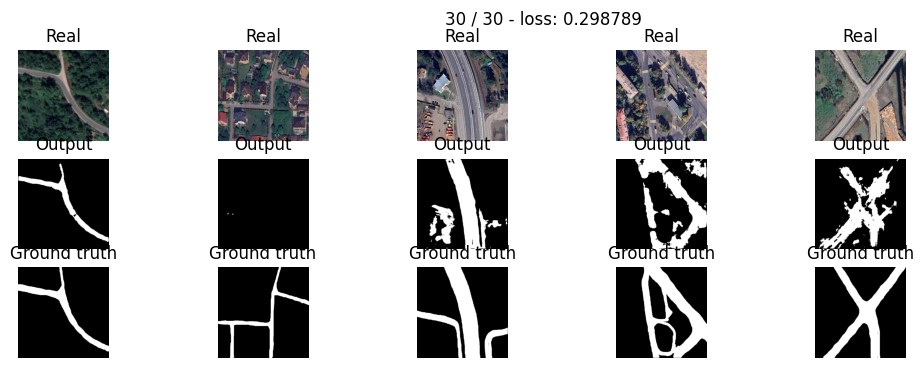

In [25]:
unet_bce_model, unet_bce_dict = train(unet_model, bce_loss, score_model, 
                                      iou_pytorch, epochs, data_tr, data_val)

In [62]:
def model_graph(
    tr: list[float], val: list[float], epochs: int, loss: bool, title: str
) -> None:
    """
    отрисовка графиков потерь и метрик
    :params tr: список потерь/метрики на трейне
    :params val: список потерь/метрики на тесте
    :params epochs: количество эпох
    :params loss: флаг графика потерь (True - отрисовка потерь, 
                  False - отрисовка метрик)
    :params title: название графика
    """
    plt.title(title)
    plt.plot(range(epochs), tr, label="train", linewidth=2)
    plt.plot(range(epochs), val, label="val", linewidth=2)
    if loss:
        plt.ylim([0, 1])
    plt.grid()
    plt.xlabel('epoches')
    plt.legend()
    plt.show()

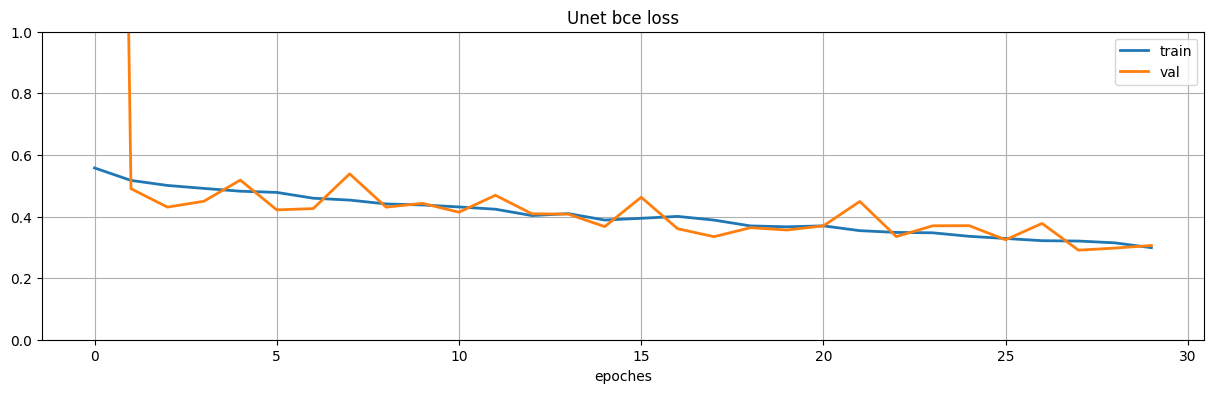

In [63]:
model_graph(unet_bce_dict['train_losses'], unet_bce_dict['val_losses'], 
            epochs, True, 'Unet bce loss')

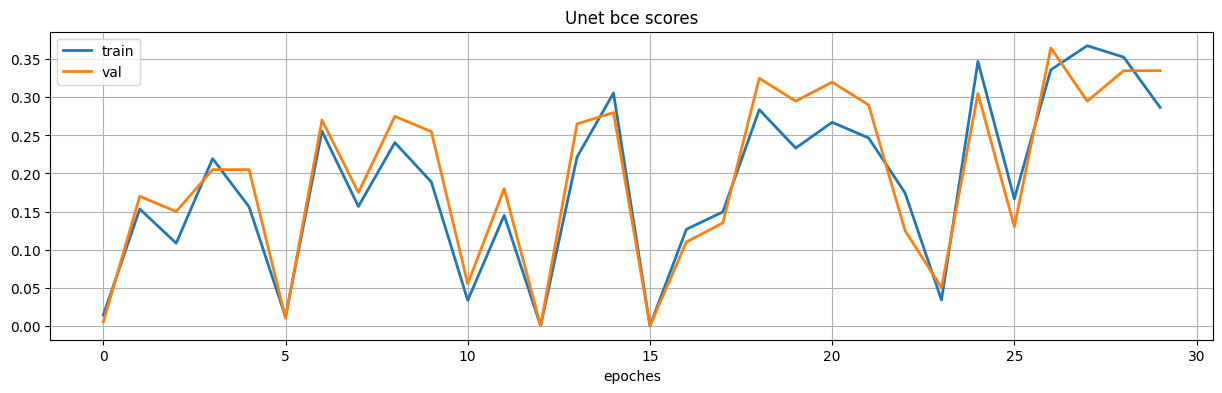

In [64]:
model_graph(unet_bce_dict['train_scores'], unet_bce_dict['val_scores'], 
            epochs, False, 'Unet bce scores')

### 2.2.2 Unet dice loss

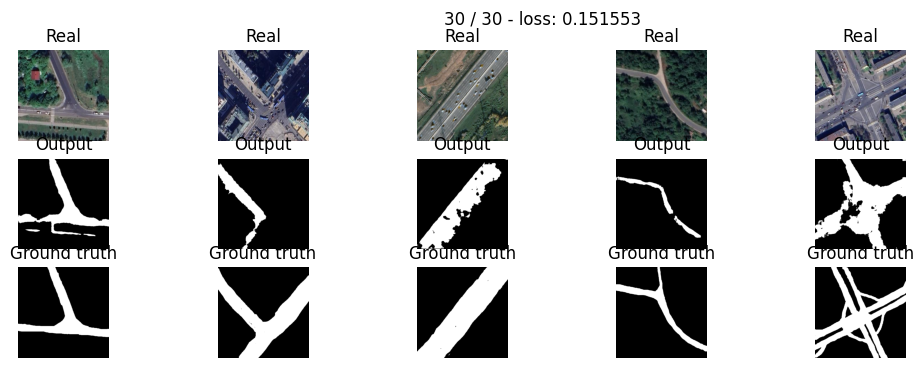

In [29]:
unet_dice_model, unet_dice_dict = train(unet_model, dice_loss, score_model, 
                                        iou_pytorch, epochs, data_tr, data_val)

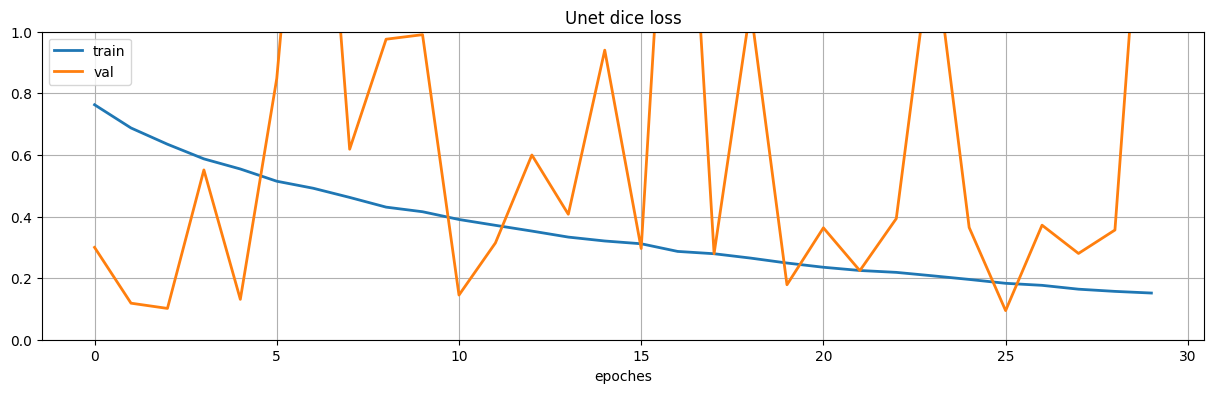

In [65]:
model_graph(unet_dice_dict['train_losses'], unet_dice_dict['val_losses'], 
            epochs, True, 'Unet dice loss')

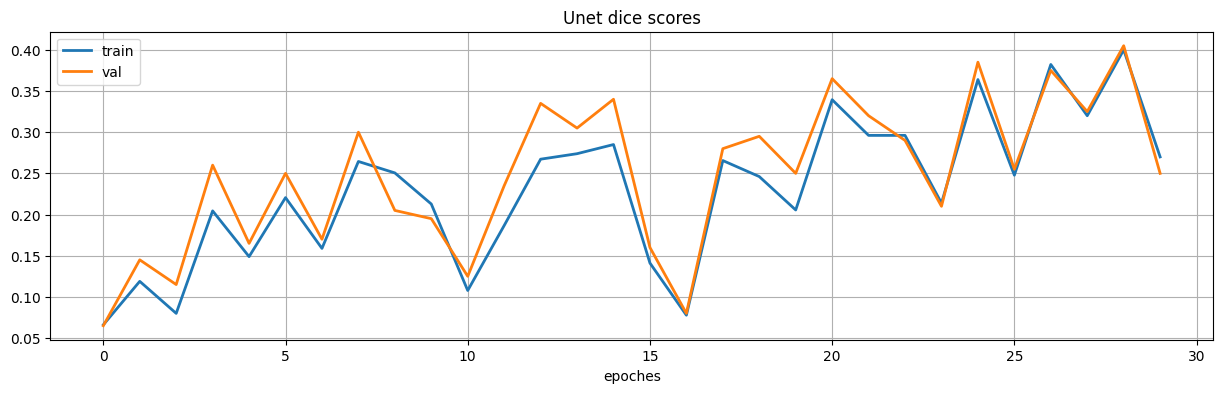

In [66]:
model_graph(unet_dice_dict['train_scores'], unet_dice_dict['val_scores'], 
            epochs, False, 'Unet dice scores')

### 2.2.3 Unet focal loss

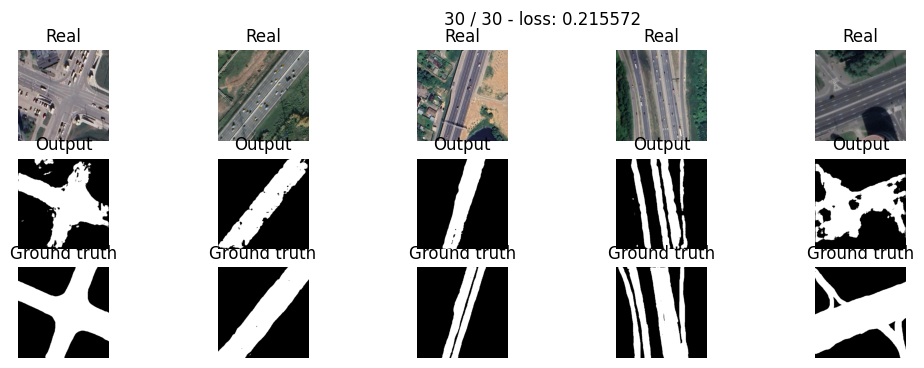

In [32]:
unet_focal_model, unet_focal_dict = train(unet_model, focal_loss, score_model, 
                                          iou_pytorch, epochs, data_tr, data_val)

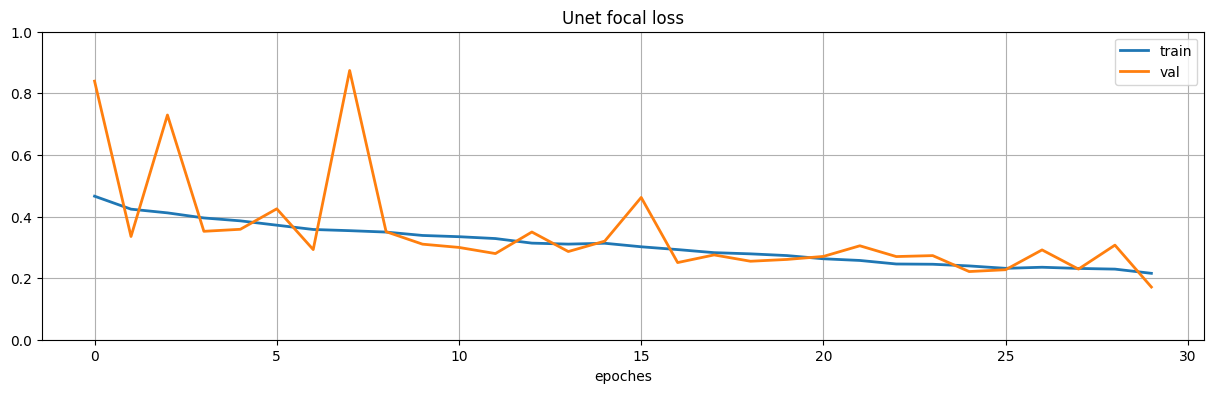

In [67]:
model_graph(unet_focal_dict['train_losses'], unet_focal_dict['val_losses'], 
            epochs, True, 'Unet focal loss')

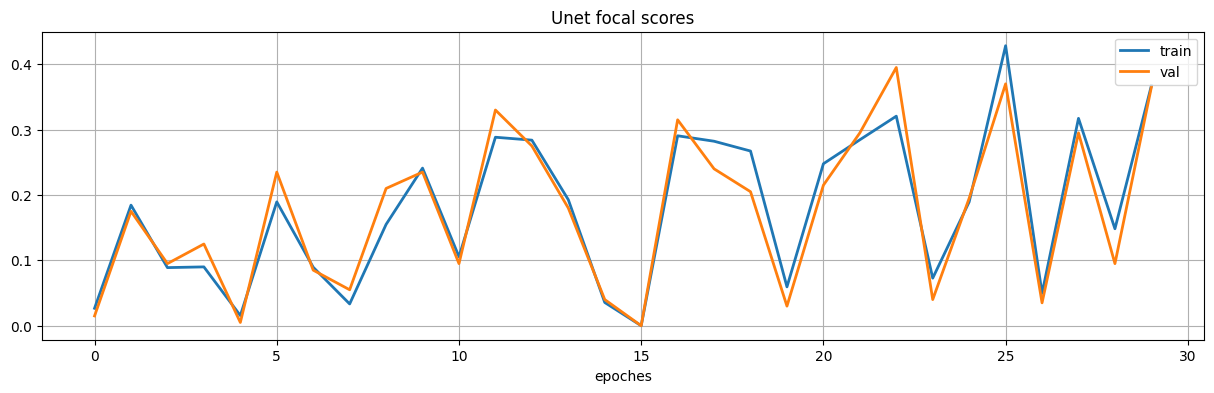

In [68]:
model_graph(unet_focal_dict['train_scores'], unet_focal_dict['val_scores'], 
            epochs, False, 'Unet focal scores')

### 2.2.4 Unet lova loss

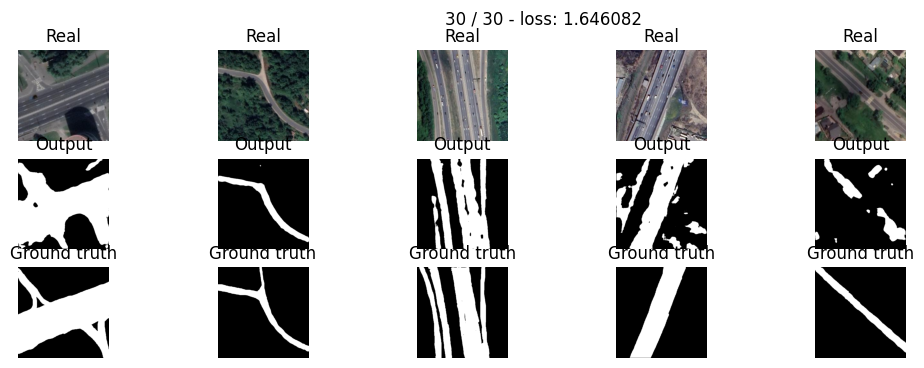

In [35]:
unet_lova_model, unet_lova_dict = train(unet_model, lovasz_hinge_flat, 
                                        score_model, iou_pytorch, epochs, 
                                        data_tr, data_val)

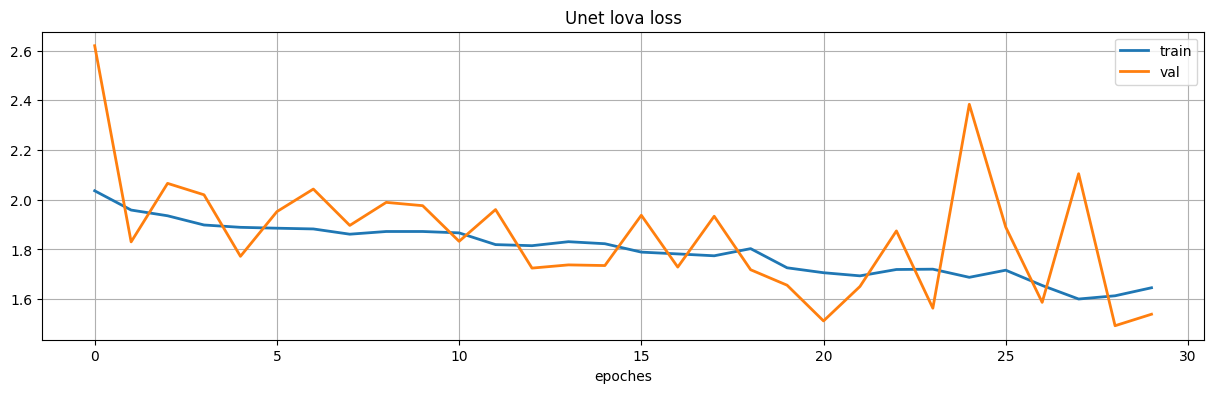

In [69]:
model_graph(unet_lova_dict['train_losses'], unet_lova_dict['val_losses'], 
            epochs, False, 'Unet lova loss')

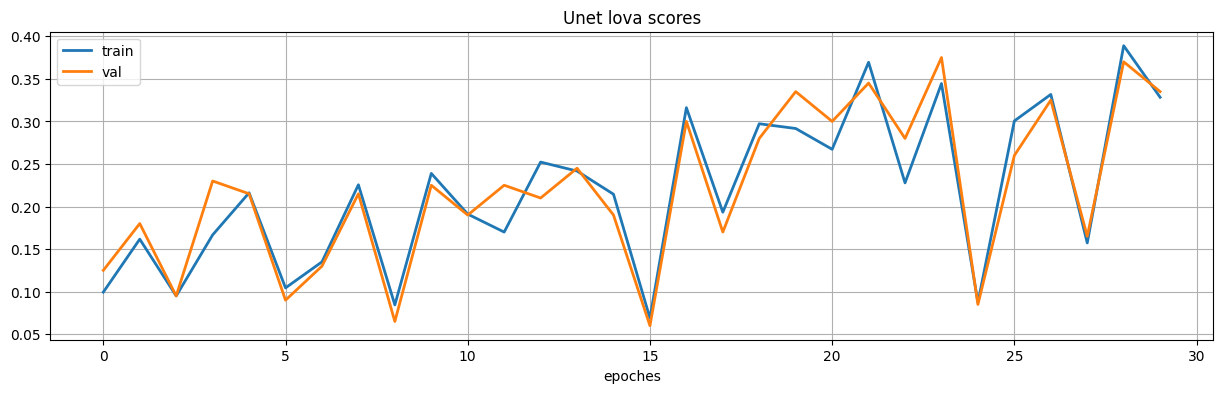

In [70]:
model_graph(unet_lova_dict['train_scores'], unet_lova_dict['val_scores'], 
            epochs, False, 'Unet lova scores')

### 2.2.5 DeepLab bce loss

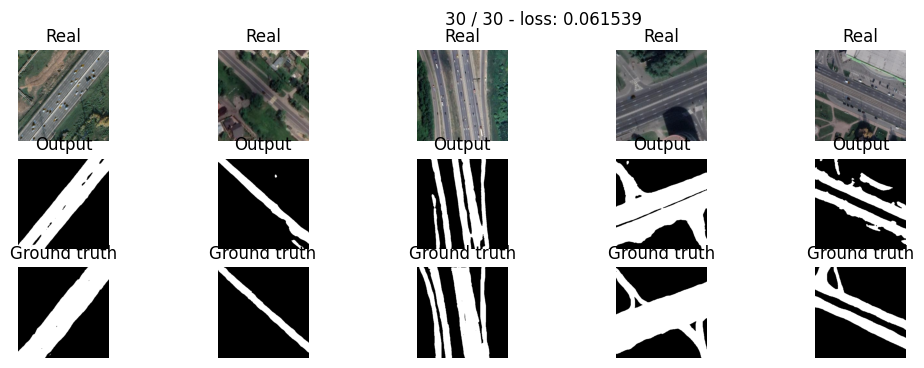

In [38]:
deeplab_bce_model, deeplab_bce_dict = train(deeplab_model, bce_loss, 
                                            score_model, iou_pytorch, epochs, 
                                            data_tr, data_val)

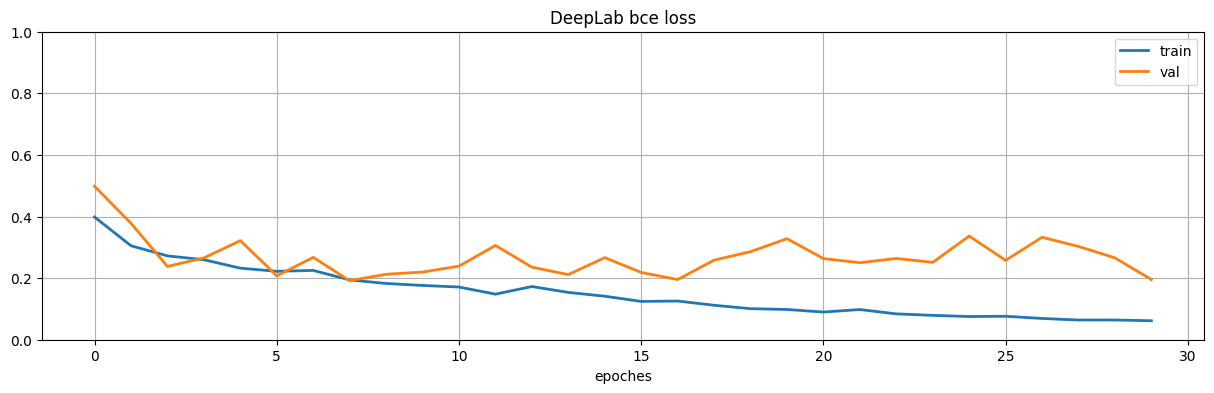

In [71]:
model_graph(deeplab_bce_dict['train_losses'], deeplab_bce_dict['val_losses'], 
            epochs, True, 'DeepLab bce loss')

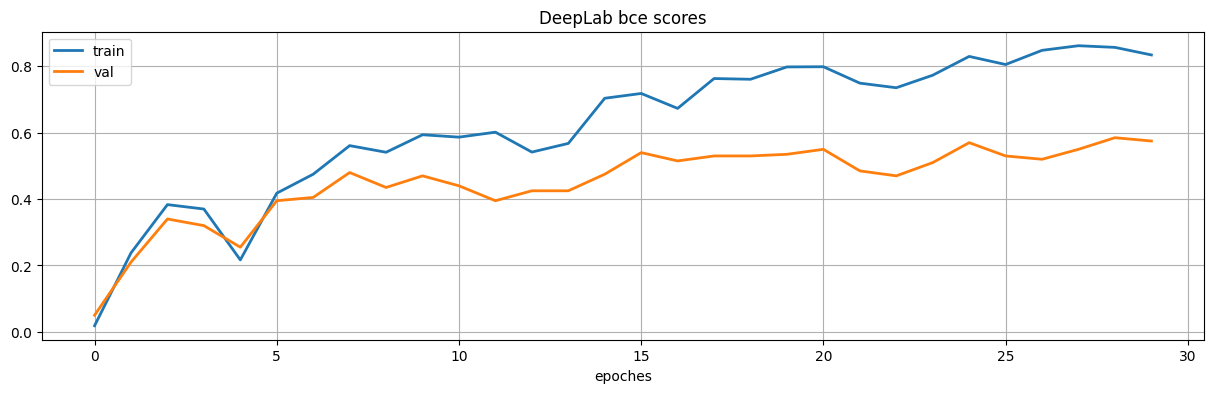

In [72]:
model_graph(deeplab_bce_dict['train_scores'], deeplab_bce_dict['val_scores'], 
            epochs, False, 'DeepLab bce scores')

### 2.2.6 DeepLab dice loss

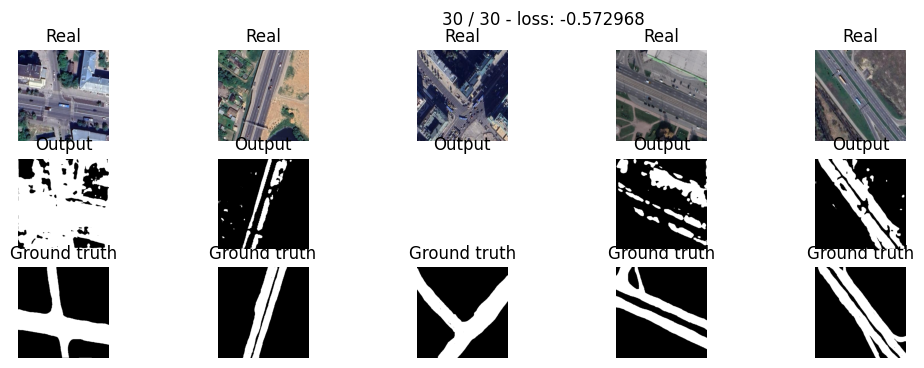

In [41]:
deeplab_dice_model, deeplab_dice_dict = train(deeplab_model, dice_loss, 
                                              score_model, iou_pytorch, 
                                              epochs, data_tr, data_val)

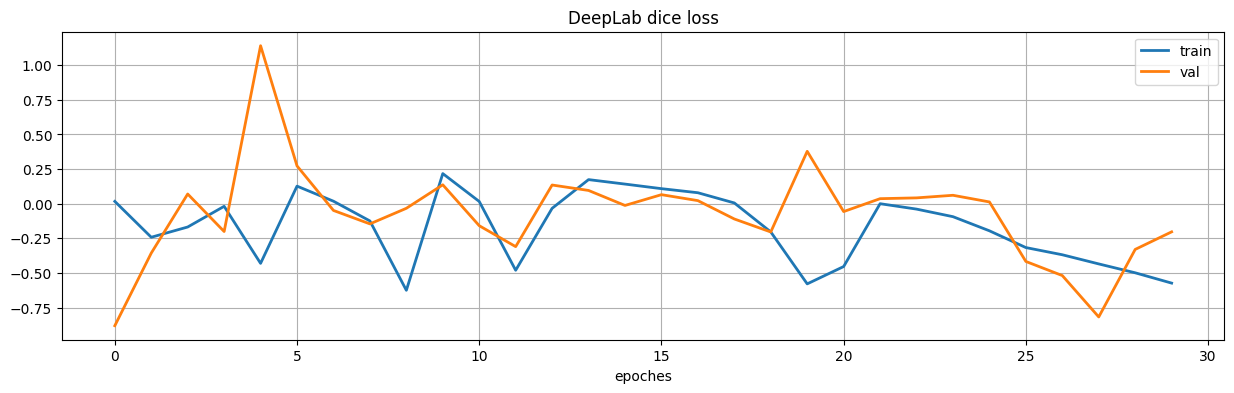

In [73]:
model_graph(deeplab_dice_dict['train_losses'], deeplab_dice_dict['val_losses'], 
            epochs, False, 'DeepLab dice loss')

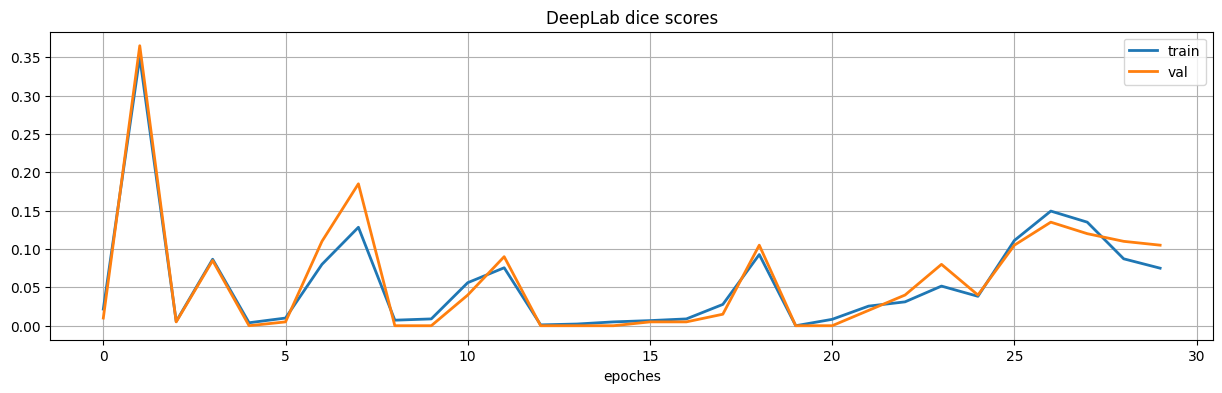

In [74]:
model_graph(deeplab_dice_dict['train_scores'], deeplab_dice_dict['val_scores'], 
            epochs, False, 'DeepLab dice scores')

### 2.2.7 DeepLab focal loss

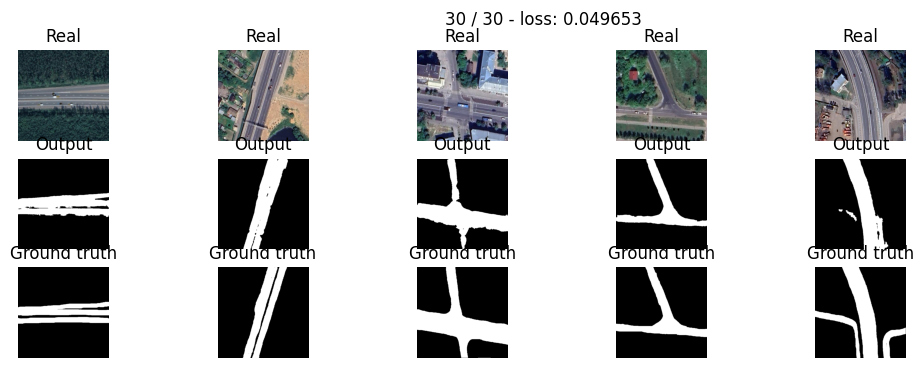

In [44]:
deeplab_focal_model, deeplab_focal_dict = train(deeplab_model, focal_loss, 
                                                score_model, iou_pytorch, 
                                                epochs, data_tr, data_val)

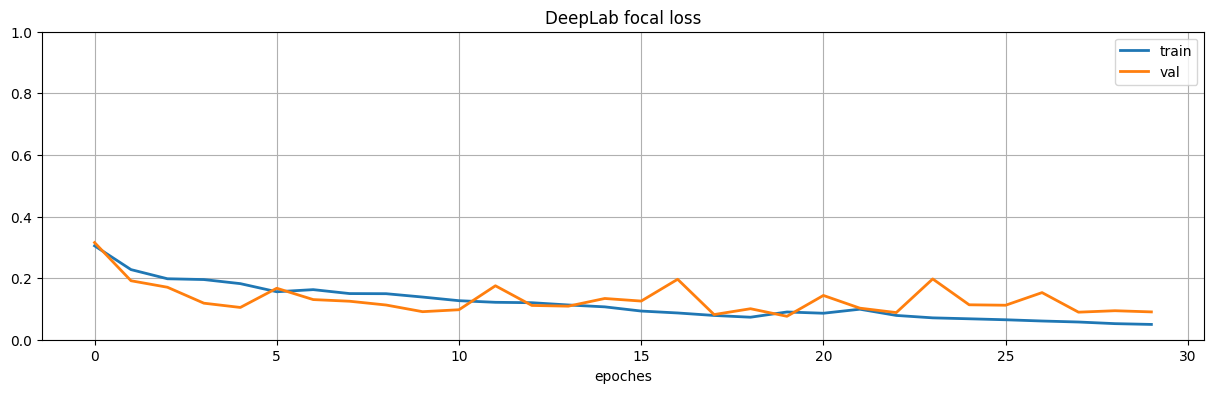

In [75]:
model_graph(deeplab_focal_dict['train_losses'], deeplab_focal_dict['val_losses'], 
            epochs, True, 'DeepLab focal loss')

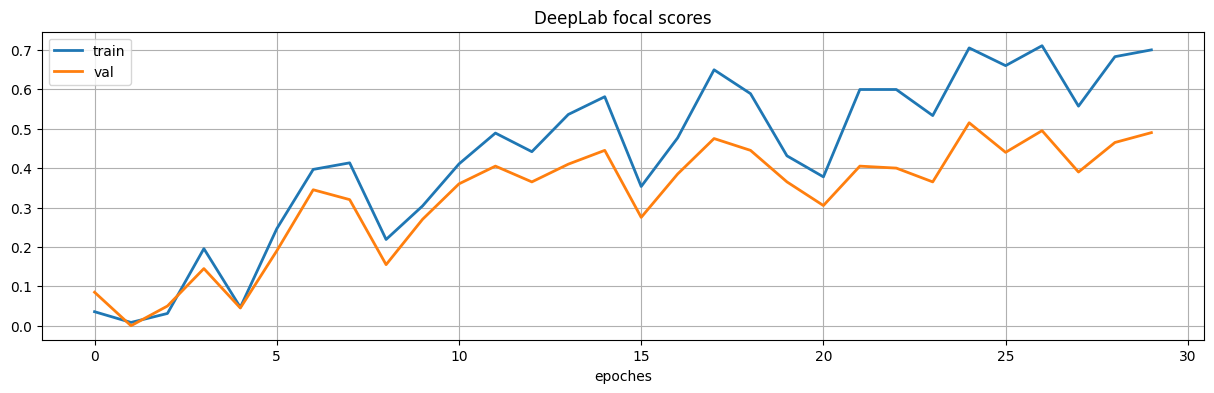

In [76]:
model_graph(deeplab_focal_dict['train_scores'], deeplab_focal_dict['val_scores'], 
            epochs, False, 'DeepLab focal scores')

### 2.2.8 DeepLab lova loss

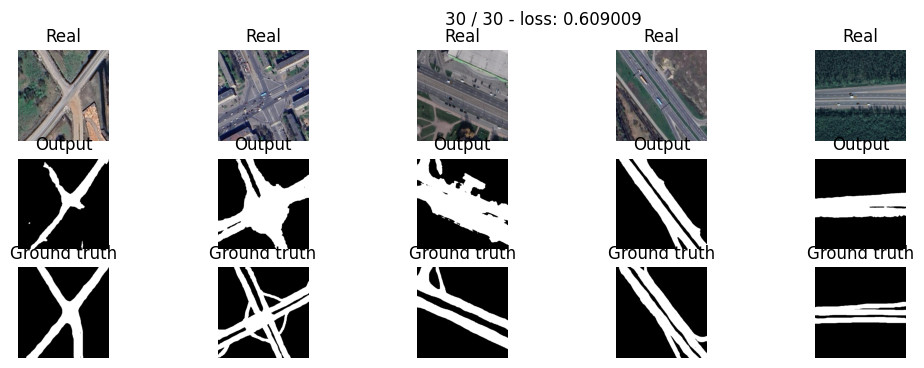

In [47]:
deeplab_lova_model, deeplab_lova_dict = train(deeplab_model, lovasz_hinge_flat, 
                                              score_model, iou_pytorch, epochs, 
                                              data_tr, data_val)

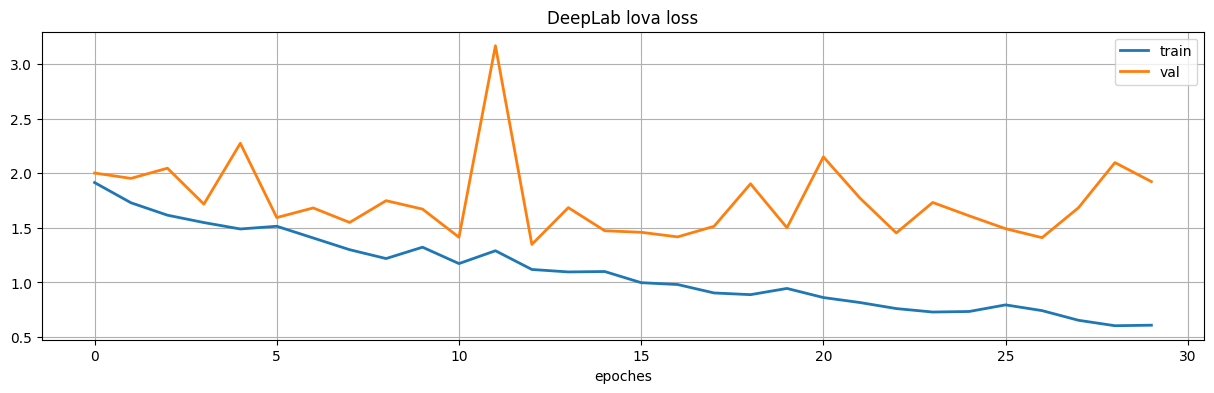

In [77]:
model_graph(deeplab_lova_dict['train_losses'], deeplab_lova_dict['val_losses'], 
            epochs, False, 'DeepLab lova loss')

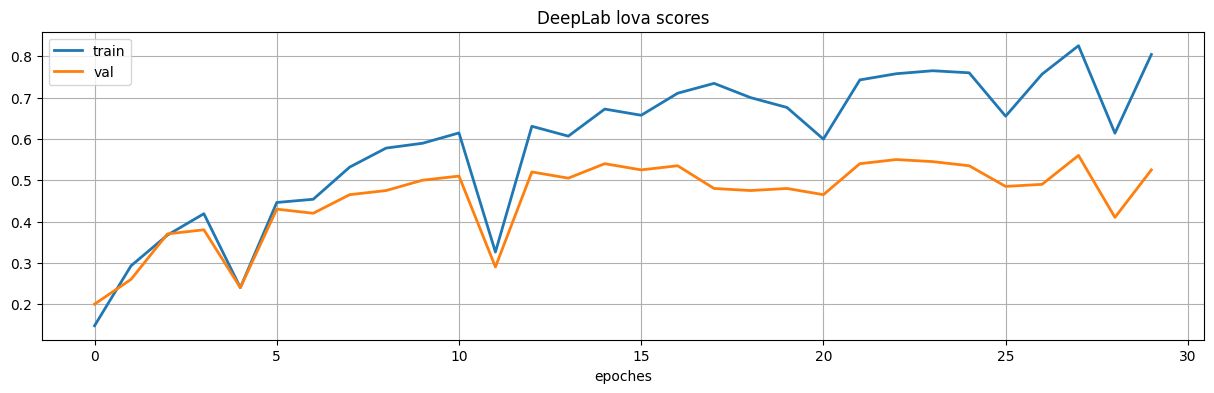

In [78]:
model_graph(deeplab_lova_dict['train_scores'], deeplab_lova_dict['val_scores'], 
            epochs, False, 'DeepLab lova scores')

## 2.3 Сравнение моделей

In [79]:
def show_scores(epochs: int, **graphs) -> None:
    """
    Отрисовка метрики всех моделей на тесте
    :params epochs: количество эпох
    :params graphs: словари потерь и метрик моделей
    """
    plt.title('Метрики моделей на валидации')
    for name, graph in graphs.items():
        plt.plot(range(epochs), graph['val_scores'], label=f'{name}'[:-5], 
                 linewidth=2)
    plt.grid()
    plt.xlabel('epoches')
    plt.legend()
    plt.show()

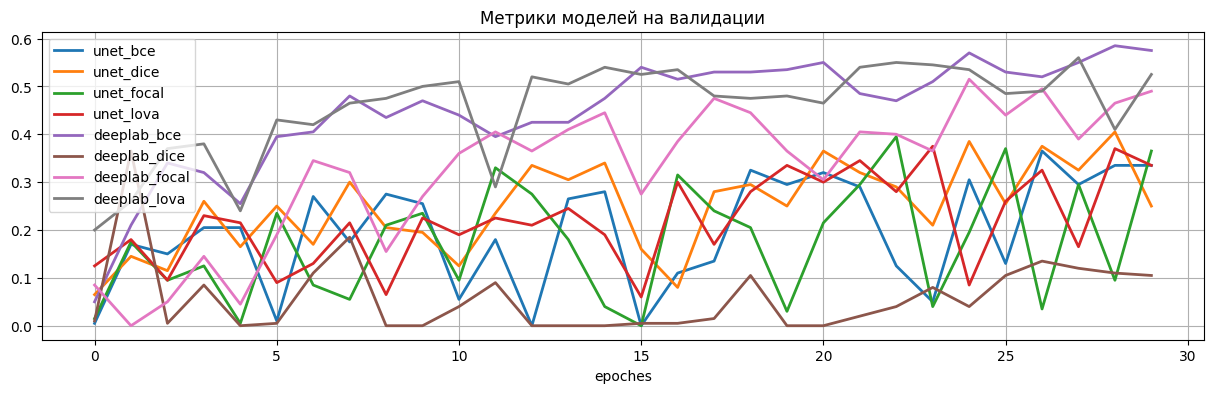

In [80]:
show_scores(epochs,
            unet_bce_dict=unet_bce_dict,
            unet_dice_dict=unet_dice_dict,
            unet_focal_dict=unet_focal_dict,
            unet_lova_dict=unet_lova_dict,
            deeplab_bce_dict=deeplab_bce_dict,
            deeplab_dice_dict=deeplab_dice_dict,
            deeplab_focal_dict=deeplab_focal_dict,
            deeplab_lova_dict=deeplab_lova_dict)

# 3. Сохранение переменных в память компьютера

Наилучшую метрику на валидации показала модель deeplab с bce loss. Сохраню параметры модели и словари.

In [ ]:
def to_pickle(data, path: str) -> None:
    """
    Сохранение данных по заданному пути в формат pickle
    :params data: данные, которые надо сохранить
    :params path: путь до файла
    """
    with open(path, 'wb') as f:
        pickle.dump(data, f)

In [4]:
unet_bce_dict_path = config['train']['unet_bce_dict_path']
unet_dice_dict_path = config['train']['unet_dice_dict_path']
unet_focal_dict_path = config['train']['unet_focal_dict_path']
unet_lova_dict_path = config['train']['unet_lova_dict_path']
deeplab_bce_dict_path = config['train']['deeplab_bce_dict_path']
deeplab_dice_dict_path = config['train']['deeplab_dice_dict_path']
deeplab_focal_dict_path = config['train']['deeplab_focal_dict_path']
deeplab_lova_dict_path = config['train']['deeplab_lova_dict_path']
deeplab_bce_weights_path = config['train']['deeplab_bce_weights_path']

In [ ]:
to_pickle(unet_bce_dict, unet_bce_dict_path)
to_pickle(unet_dice_dict, unet_dice_dict_path)
to_pickle(unet_focal_dict, unet_focal_dict_path)
to_pickle(unet_lova_dict, unet_lova_dict_path)
to_pickle(deeplab_bce_dict, deeplab_bce_dict_path)
to_pickle(deeplab_dice_dict, deeplab_dice_dict_path)
to_pickle(deeplab_focal_dict, deeplab_focal_dict_path)
to_pickle(deeplab_lova_dict, deeplab_lova_dict_path)

In [82]:
torch.save(deeplab_bce_model.state_dict(), deeplab_bce_weights_path)